In [1]:
from helper_methods import *
from visualizations import *

Creation of DB Tables


In [2]:
# IMPORTANT: THIS STEP WAS ALREADY DONE. THIS IS A VERY TIME CONSUMING CODE BLOCK
# DO NO UNCOMMENT AND RERUN
# from seed_db import seed_stock_info, seed_stock_coint_pairs
# seed_stock_info()
# seed_stock_coint_pairs()

These two functions create two database tables which we can access as a DataFrame.

One DF has all the Stock Prices over the time period:


In [3]:
stock_price_df = get_stock_prices_from_db()
stock_price_df.sample(5)

,id,ticker,sector,price,date
119359,119360,MMM,industrials,173.01,2021-03-31
183150,183151,RBA,industrials,37.45,2020-06-23
23626,23627,CI,healthcare,202.79,2021-08-10
5332,5333,ABBV,healthcare,87.51,2020-11-11
290944,290945,EPAM,technology,348.70,2023-01-23


The other DF contains all the coint pairs that were identified.


In [4]:
stock_coint_df = get_stock_coint_pairs_from_db()
stock_coint_df.head(5)

,id,stock_one,stock_two,pvalue,sector,ratio_stationarity
0,1,AAPL,INFY,0.04932,technology,0.04434
1,2,AAPL,SNPS,0.04729,technology,0.00253
2,3,MSFT,NVDA,0.03756,technology,0.16499
3,4,ACN,MSFT,0.00665,technology,0.00472
4,5,INFY,MSFT,0.02888,technology,0.28849


We sorted our stock_coint_df by p-value and used a heatmap to assist us in which stock pair to use. We only analyzed the top 3 pair to keep the visualization clean.

In [5]:
stock_coint_df_sorted = stock_coint_df.sort_values(by=['pvalue', 'ratio_stationarity'])

top_pairs = []

for pairs in range(3):
    stock_one, stock_two = stock_coint_df_sorted.iloc[pairs][['stock_one', 'stock_two']].to_numpy()
    top_pairs.append(stock_one)
    top_pairs.append(stock_two)

print(top_pairs)

['PODD', 'RGEN', 'ALC', 'LH', 'AME', 'NSC']


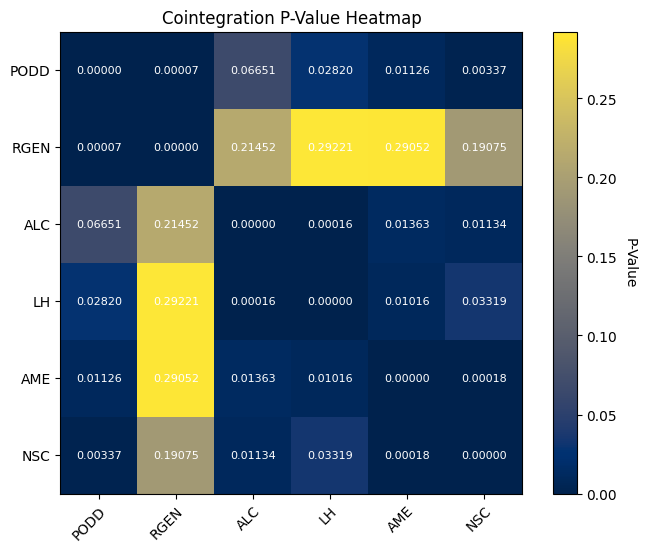

In [6]:
create_cointegration_heatmap(top_pairs, TRAINING_DATE_RANGE)

For simplicity, we will just use the cointegrated pair with the lowest p-value to conduct our trades.

In [7]:
index_of_chosen_pair = 0

stock_one, stock_two = stock_coint_df.sort_values(by=['pvalue', 'ratio_stationarity']).iloc[index_of_chosen_pair][[
    'stock_one', 'stock_two']].to_numpy()
stock_one, stock_two

('PODD', 'RGEN')

We will split our data into 4 years of training data and 1 year of testing data.

In [8]:
pair_stock_price_df = stock_price_df[stock_price_df['ticker'].isin([stock_one, stock_two])]


def gen_date(str_date): return date(*[int(n) for n in str_date.split('-')])
train_start_date = gen_date(TRAINING_DATE_RANGE[0])
train_end_date = gen_date(TRAINING_DATE_RANGE[1])
test_start_date = gen_date(TESTING_DATE_RANGE[0])
test_end_date = gen_date(TESTING_DATE_RANGE[1])

training_df = pair_stock_price_df[(pair_stock_price_df['date'] >= train_start_date) & (
    pair_stock_price_df['date'] <= train_end_date)]
training_df = training_df.set_index('date')

test_df = pair_stock_price_df[(pair_stock_price_df['date'] >= test_start_date) & (
    pair_stock_price_df['date'] <= test_end_date)]
test_df = test_df.set_index('date')

train_stock_one_price_series = training_df[training_df['ticker']
                                           == stock_one]['price']
train_stock_two_price_series = training_df[training_df['ticker']
                                           == stock_two]['price']

test_stock_one_price_series = test_df[test_df['ticker']
                                      == stock_one]['price']
test_stock_two_price_series = test_df[test_df['ticker']
                                      == stock_two]['price']

Before we look start training with our train data, let's take a look at our two stock prices over our entire 5 years of data.

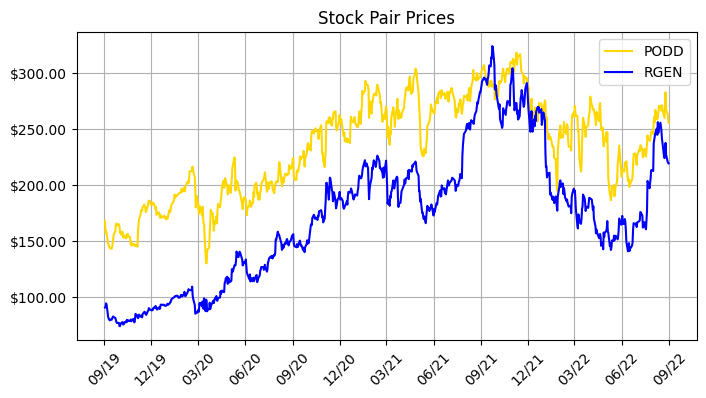

In [9]:
plot_stock_pair(train_stock_one_price_series, stock_one,
                train_stock_two_price_series, stock_two)

We can see that they appear to be cointegrated and moving together, but PODD's price is slightly higher than RGEN most of the time, so let's normalize this data so we can see the price comparison on the same scale.

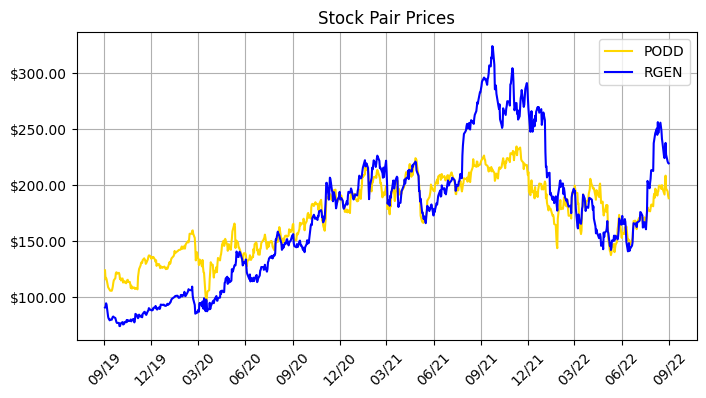

In [10]:
plot_stock_one_adjusted_pair(train_stock_one_price_series, stock_one,
                             train_stock_two_price_series, stock_two)

This gives us a better view, and acts as a smell test that nothing jumps out to us as terribly wrong with our assumption that these two stock prices are cointegrated. Next, we'll want to look at the spread between the two stocks, so let's visualize the ratio between the two stocks. Note that we are now narrowing our focus to the training data.

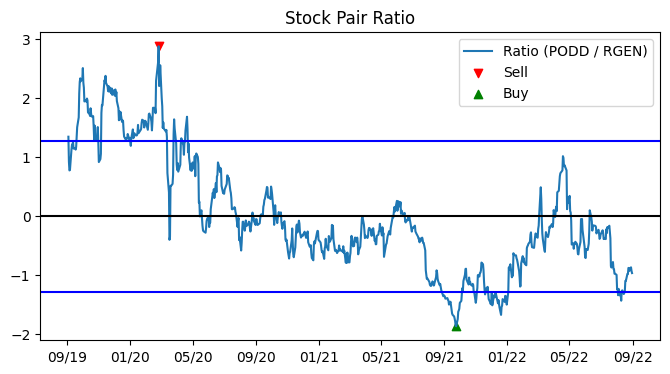

In [11]:
plot_stock_pair_ratio(train_stock_one_price_series, stock_one,
                      train_stock_two_price_series, stock_two)

# Note for Ryan, add something to the graph below marking we would trade at the high point near the beginning (2019), and at the low point near the end (2022)

We can see that the ratio does not appear perfectly stationary, which is commonly the case with real, messy data. Note that ~80% of our data is in between the blue lines (representing z-score). This means that only 20% of our data is outside the blue lines, so if we see our ratio go outside the blue lines, this would be an irregular finding. Thus, if our assumption that the ratio is stationary holds, we can trade during these "irregular" times then make money when the ratio reverts back to normal (in between the blue lines). Specifically, we will want to sell the spread if the ratio is over the blue threshold, and buy the spread if the ratio is under the blue threshold (more on buying and selling the spread later for those who are unfamiliar with the terms). It is critical to note that predictions from this graph have look-ahead bias, which is an incredibly common form of data leakage when working with time series data. In order to address this issue, we will use rolling moving averages to calculate the z_score threshold to use.

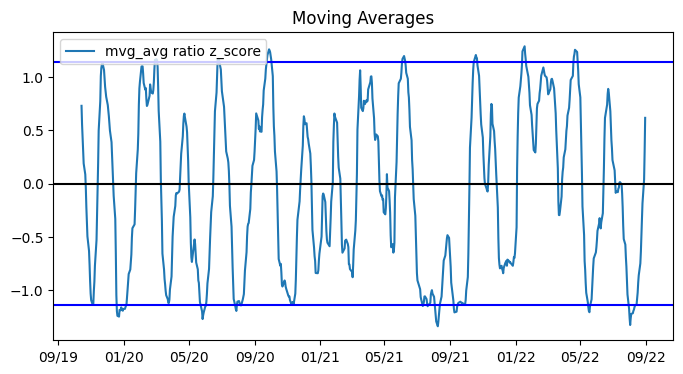

In [12]:
train_ratio = train_stock_one_price_series / train_stock_two_price_series
test_ratio = test_stock_one_price_series / test_stock_two_price_series
plot_mvg_avg_ratio(train_ratio, test_ratio)

Now, with moving averages, we can see that the predictive power isn't as great. In the first graph, there was a very clear period where we could sell high, and a very clear period where we could buy low. With this new graph using moving averages, there are a lot of trading signals, and the data sometimes fluctuates back and forth around the blue lines. Of course, if we don't have look-ahead bias, then we will not have as strong predictions. Now, let's see how our training set does with buying and selling the spread. In order to profit, we'll want to buy low and sell high.

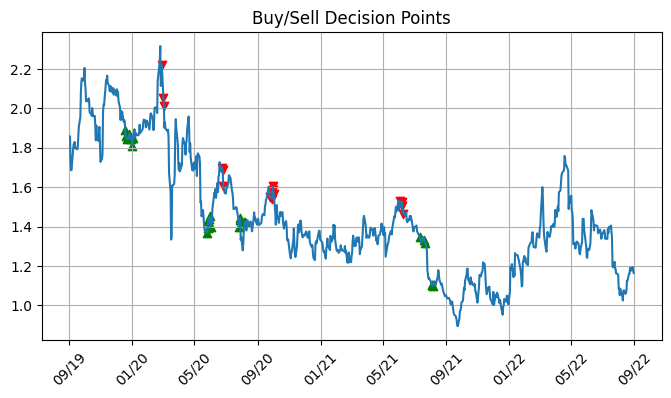

In [13]:
plot_trade_signals(train_ratio, test_ratio)

The green arrows represent signals that our algorithm bought the spread, and the red arrows represent signals that our algorithm sold the spread. When the z-score is below the band, that means that stock 1 (PODD) is undervalued compared to stock 2 (RGEN), so we will buy the spread, which means long stock 1 and short stock 2. When the z-score is above the band, that means that stock 1 (PODD) is overvalued compared to stock 2 (RGEN), so we will sell the spread, which means short stock 1 and long stock 2. We've designed this to take an equal long and short position of $100 at every trade, which you'll notice requires $0 initial cash outlay. Luckily, it looks like our algorithm did very well with buying low and selling high. Let's go ahead and repeat what we've done here with our test data. We will use the z-score (blue line) threshold that we've calculated with the train data in order to avoid look ahead bias. This algorithm is intended to be used on future data, for which we won't have a z-score threshold for right now.

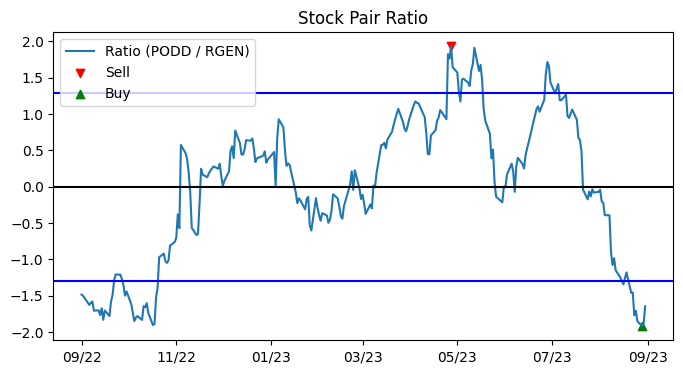

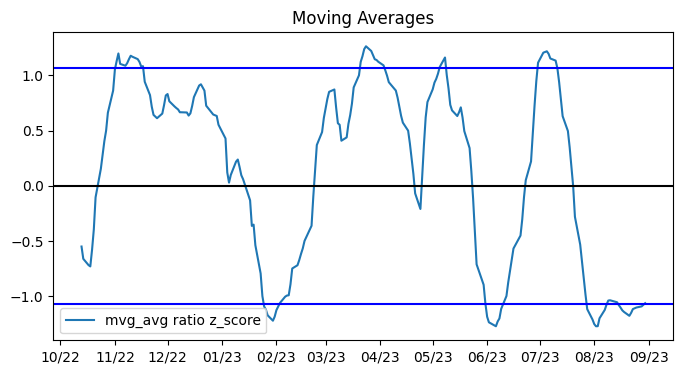

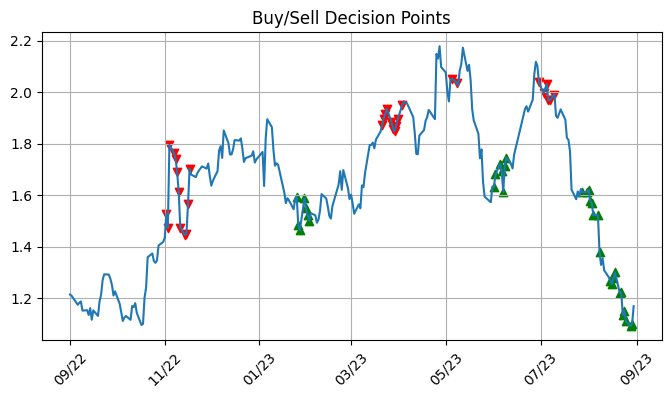

In [14]:
plot_stock_pair_ratio(test_stock_one_price_series, stock_one,
                      test_stock_two_price_series, stock_two)
plot_mvg_avg_ratio(test_ratio, train_ratio)
plot_trade_signals(test_ratio, train_ratio)

Let's calculate profit from our test

In [15]:
profit = calculate_profit(test_stock_one_price_series ,test_stock_two_price_series, test_ratio, train_ratio)[0]
print('The profit is $' + str(profit))

The profit is $506.9410918173846


Our profit looks quite good for only a year of investing and $0 initial cash outlay. It even looks like we ended our trades in a position where the spread is undervalued, so we think we'll make even more money in the next few months. If we were willing to take on more risk, we could have increased our long and short positions to $1,000 every time we trade the spread, and we would have made 10x the profit. Or $1,000,000 long and short positions to make 10000x the profit. We could have also tuned the z-score threshold (blue line) to trade more conservatively or aggressively, depending on the risk profile we are willing to take on.

In [16]:
profit_trend = calculate_profit(test_stock_one_price_series ,test_stock_two_price_series, test_ratio, train_ratio)[1]['Cumulative Profit']
# TO DO FOR RYAN: compare profit trend to owning and holding $100 of SP500 (or whatever value makes sense)

It looks like our algorithm performed very well. Our 2 stocks remained cointegrated in our test period, and we make a positive profit. Let's see what happens when that cointegrated assumption doesn't hold.

In [17]:
dated_stock_price_df = stock_price_df.set_index('date')
non_coint_stock_one_series = dated_stock_price_df[dated_stock_price_df['ticker'] == 'HON']['price']
non_coint_stock_two_series = dated_stock_price_df[dated_stock_price_df['ticker'] == 'NVO']['price']
non_coint_stock_one = 'HON'
non_coint_stock_two = 'NVO'
test_stock_cointegration(non_coint_stock_one_series, non_coint_stock_two_series)

(False,
 (-1.8800437335091151,
  0.5900931106769007,
  array([-3.90737061, -3.34221646, -3.04867279])))

We just took two random stocks from different industries, HON from industrials and NVO from healthcare, and we can see that the p-value from our cointegration test is 0.59, which is over our threshold of 0.05, and we can assume that these stocks are not cointegrated.

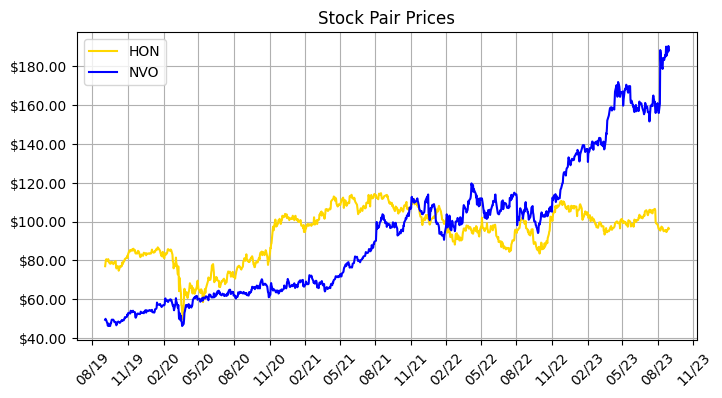

In [18]:
plot_stock_one_adjusted_pair(non_coint_stock_one_series, non_coint_stock_one,
                             non_coint_stock_two_series, non_coint_stock_two)

For this example, we didn't split the data into train and test, because we aren't looking for actual trading results. We just want to show off how this trading strategy will not work with two stocks that are not cointegrated.

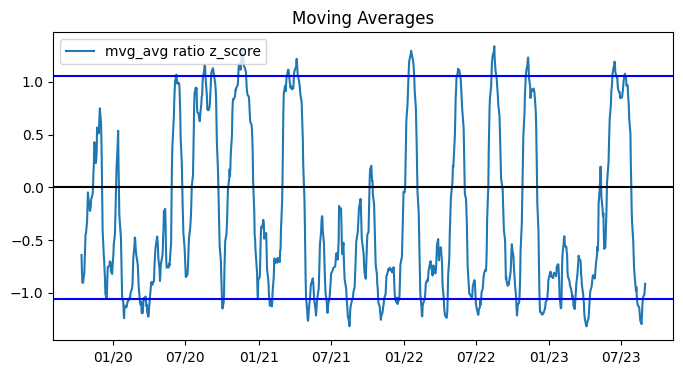

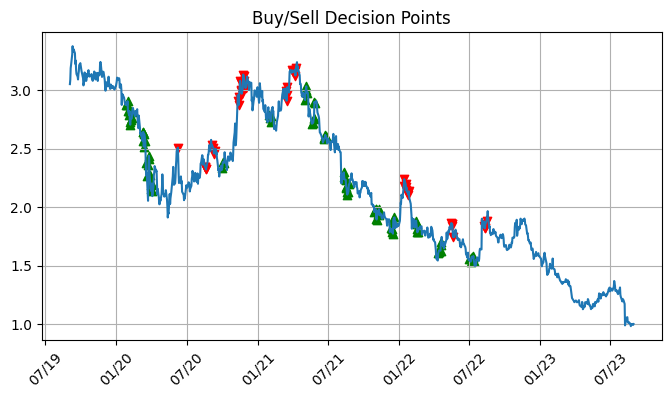

The profit is $-350.3575222655282


In [19]:
non_coint_ratio = non_coint_stock_one_series / non_coint_stock_two_series
plot_mvg_avg_ratio(non_coint_ratio, non_coint_ratio)
plot_trade_signals(non_coint_ratio, non_coint_ratio)
print('The profit is $' + str(calculate_profit(non_coint_stock_one_series, non_coint_stock_two_series, non_coint_ratio, non_coint_ratio)[0]))

#add in the profit trend for this one. We should see that the strategy starts profitable, but then starts to lose money, and we cut it off
# calculate_profit(non_coint_stock_one_series, non_coint_stock_two_series, non_coint_ratio, non_coint_ratio)[1]


We can see that when compared side by side, HON and NVO appear to move together, but start to diverge at the beginning of 2023. We can also see that ratio z-scores seem centered below 0, which is an indication the series is not stationary. Also, the range of the ratio z-scores is wider than our previous example. These indications that the pair is not cointegrated are subtle, both because our data is heavily smoothed with moving averages, and because cointegration tests like ADF are sometimes better than humans at catching non-cointegration. You'll see our algorithm stopped trading at the beginning of 2023. That is because we set a stop loss if we see our ratio z-scores cross a certain threshold. In other words, once the stock prices show signs of no longer being cointegrated, we stop the strategy and exit out of all positions. Let's see what would have happened if we did not stop our strategy.

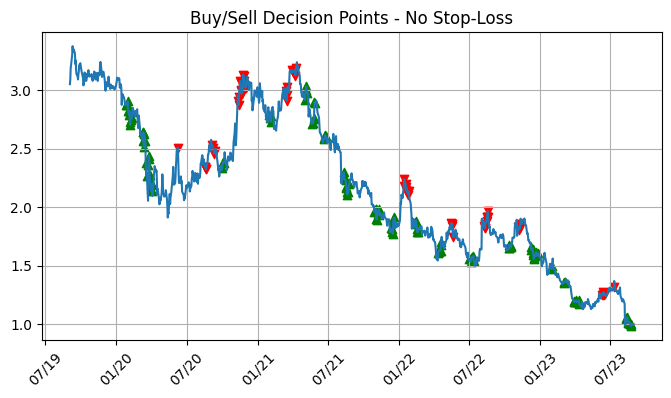

The profit is $-5667.255135811542


In [20]:
plot_trade_signals_no_stop_loss(non_coint_ratio, non_coint_ratio)
print('The profit is $' + str(calculate_profit_no_stop_loss(non_coint_stock_one_series, non_coint_stock_two_series, non_coint_ratio, non_coint_ratio)[0]))

Without stop loss, our profit was -$5667, but with stop loss, our profit was -$350. Good thing we got out of there early!